In [255]:
#Librerías
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage.color import rgb2hsv,rgb2gray,hsv2rgb
from FCF import transform
from sklearn.cluster import KMeans
import datetime
import matplotlib.dates as mdates
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny

In [218]:
#Funciones

def black_hsv(x):
    t1=x[2]<=0.15
    t2=x[1]<=0.25
    t3=x[2]<=0.7
    
    return t1 or (t2 and t3)
    
    
def detect_color(X):
    zz=X[np.where(X[:,:,1]>0.15)][np.where(X[np.where(X[:,:,1]>0.15)][:,2]>0.33)]
    color=np.median(zz[:,0])
    if color<0.1666 or color>0.761:
        color='R'
    elif color < 0.416:
        color='G'
    else:
        color='B'
    return color

def G_hsv(x):
    #Definición de los verdes posibles de la cuadrícula
    t1=x[0]>=0.2 and x[0]<=0.416
    t4=x[1]>=0.13 and x[1]<=1
    t5=x[2]>=0.25 and x[2]<=0.82
    
    return t1 and t4 and t5

def R_hsv(x):
    #Definición de los rojos posibles de la cuadrícula
    t1=x[0]>=0 and x[0]<=0.05
    t2=x[0]>=0.8555 and x[0]<=1
    t3= t1 or t2
    t4=x[1]>=0.22 and x[1]<=0.71
    t5=x[2]>=0.78 and x[2]<=1
    
    return t3 and t4 and t5

def h_lines(mask):
    tested_angles = np.linspace(np.pi/4, 3*np.pi/4 , 360, endpoint=False)
    h, theta, d = hough_line(mask, theta=tested_angles)
    a,b,c=hough_line_peaks(h, theta, d)
    return 90-np.median(np.rad2deg(b)),np.round(np.sort(np.sin(b)*c)).astype(int)

def v_lines(mask):
    tested_angles = np.linspace(-np.pi/4, np.pi/4 , 360, endpoint=False)
    h, theta, d = hough_line(mask, theta=tested_angles)
    a,b,c=hough_line_peaks(h, theta, d)
    
    return int(np.median(np.diff(np.sort(np.cos(b)*c))))


def cut(p):
    #separación de las dos imágenes
    kmeans=KMeans(n_clusters=3,random_state=777)
    r=kmeans.fit_predict(p.reshape(-1,1))
    last=r[-1]
    a1=p[r!=last]
    a2=p[r==last]
    h1=a1[0]
    l1=a1[-1]
    h2=a2[0]
    l2=a2[-1]
    

        
    return h1,l1,h2,l2

def yt_1(y,h):
    #trasformacion de HR1
    return (160/h)*(h-y)+50

def yt_2(y,h):
    #transformación de TOCO
    return (100/h)*(h-y)

def xt(x,step:int):
    #transformación del tiempo
    seg=30/step
    
    return x*seg

In [3]:
a=io.imread('./verde.jpg')
hsv=rgb2hsv(a)
mask=np.apply_along_axis(G_hsv,2,hsv)*1
mask=canny(mask.astype(float))*1

angulo,p=h_lines(mask)
if angulo!=0:
        (h, w) = a.shape[:2]
        centro = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(centro, -angulo, 1.0)
        a = cv2.warpAffine(a, M, (w, h),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        hsv=cv2.warpAffine(hsv, M, (w, h),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

mask=np.apply_along_axis(G_hsv,2,hsv)*1
mask=canny(mask.astype(float))*1
angulo,p=h_lines(mask)
h1,l1,h2,l2=cut(p)

A1=hsv[h1:l1]
A2=hsv[h2:l2]
step=v_lines(mask)
#a1=detect_line(A1,step)


In [220]:
line=np.apply_along_axis(lambda x:black_hsv(x) and not G_hsv(x),2,A1)*1

In [226]:
tested_angles = np.linspace(-np.pi/4, np.pi/4 , 360, endpoint=False)
h, theta, d = hough_line(canny(line.astype(float)), theta=tested_angles)
a,b,c=hough_line_peaks(h, theta, d)

In [235]:
for i in np.sort(np.cos(b)*c):
    line[:,int(i)-5:int(i)+5]=0

<IPython.core.display.Javascript object>


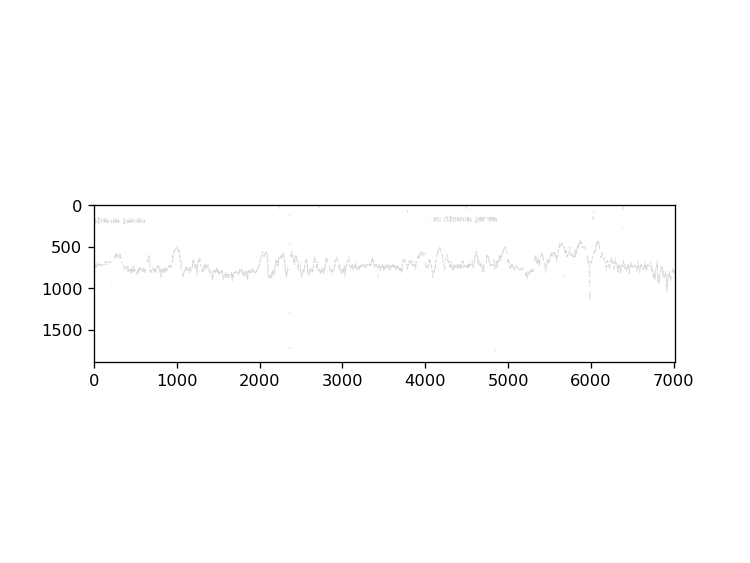

In [247]:
plt.imshow(1-canny(line.astype(float),sigma=3),cmap='gray')

<IPython.core.display.Javascript object>


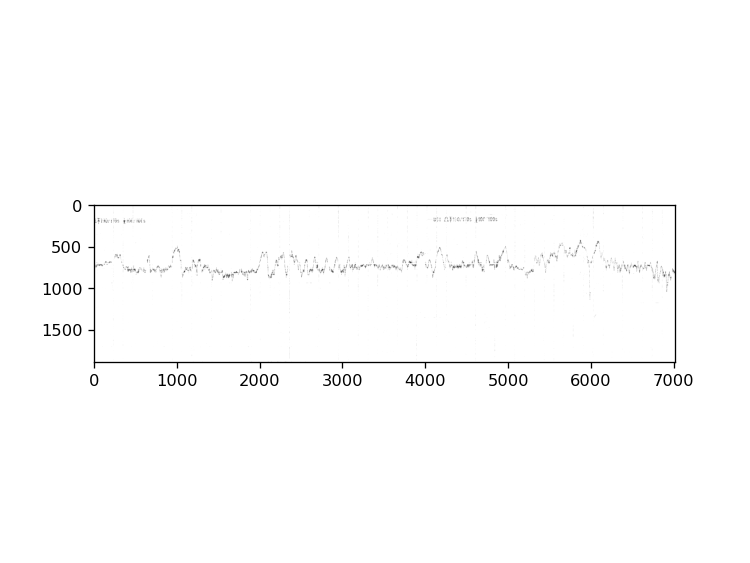

In [236]:
%matplotlib notebook
plt.imshow(1-line,cmap='gray')

<IPython.core.display.Javascript object>


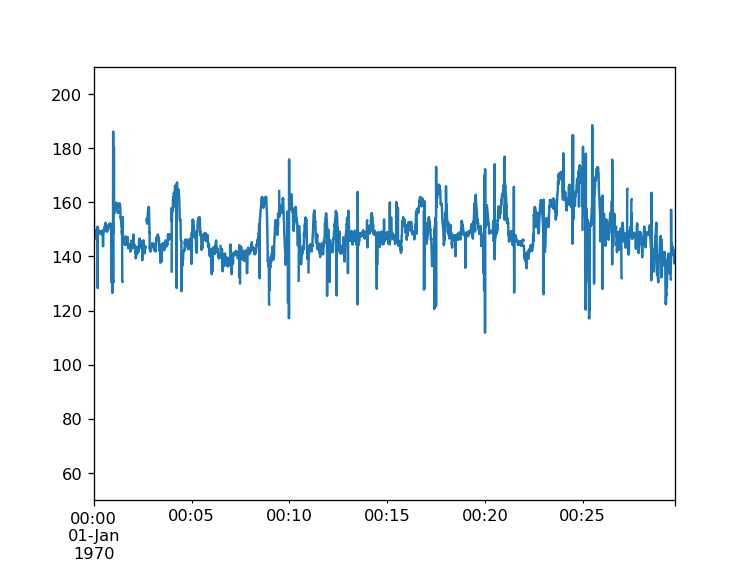

(50.0, 210.0)

In [254]:
detect_line(A1,step,grid=G_hsv).plot()
plt.ylim(50,210)

In [252]:
def detect_line(A,step,Y=yt_1,grid=R_hsv):
    line=np.apply_along_axis(lambda x:black_hsv(x) and not grid(x),2,A)*1
    y,x=np.where((line))
    y=Y(y,A.shape[0])
    x=xt(x,step)
    d=pd.DataFrame(sorted(zip(x,y)))
    if Y==yt_1:
        d=d[d.loc[:,1]<=190]
        d=d[d.loc[:,1]>=60]
    elif Y==yt_2:
        d=d[d.loc[:,1]<=90]
    d=d.groupby(0).median()
    x=d.index
    y=d[1].values
    
    s=d.rolling(round(step),center=True).std().backfill().ffill()
    m=d.rolling(round(step),center=True).median().backfill().ffill()
    
    dele=[]
    for i in range(len(y)):
        if y[i]>(m+2.5*s).iloc[i,0] or y[i]< (m-2.5*s).iloc[i,0]:
            dele.append(i)

    for i in dele:
         y[i]=m.iloc[i,0]
            
            
    a=pd.Series(y,index=pd.DatetimeIndex(x*1e9))
    return a.resample('0.25S').median().ffill(limit=2)

In [417]:
def scan(img):
    A=img.copy()
    Hsv=rgb2hsv(A)
    color=detect_color(Hsv)
    if color=='R':
        mask=np.apply_along_axis(R_hsv,2,Hsv)*1
    elif color=='G':
        mask=np.apply_along_axis(G_hsv,2,Hsv)*1
    else:
        raise ValueError
    mask=canny(mask.astype(float))*1
    angulo,p=h_lines(mask)
    if angulo!=0:
        (h, w) = A.shape[:2]
        centro = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(centro,- angulo, 1.0)
        A = cv2.warpAffine(A, M, (w, h),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        Hsv=cv2.warpAffine(Hsv, M, (w, h),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    if color=='R':
        mask=np.apply_along_axis(R_hsv,2,Hsv)*1
    elif color=='G':
        mask=np.apply_along_axis(G_hsv,2,Hsv)*1
    else:
        raise ValueError
    
    h1,l1,h2,l2=cut(p)

    fig,ax=plt.subplots(2,1,sharex=True,height_ratios=(0.66,0.33),figsize=(20,20))
    ax[0].imshow(A[h1:l1])
    ax[1].imshow(A[h2:l2])
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    plt.show()

    A1=Hsv[h1:l1]
    A2=Hsv[h2:l2]
    #Continue??
    
    #A1
    
    step=v_lines(mask)
    
    a1=detect_line(A1,step,Y=yt_1)
    
    
    #A2
    
    a2=detect_line(A2,step,Y=yt_2)

    return a1,a2

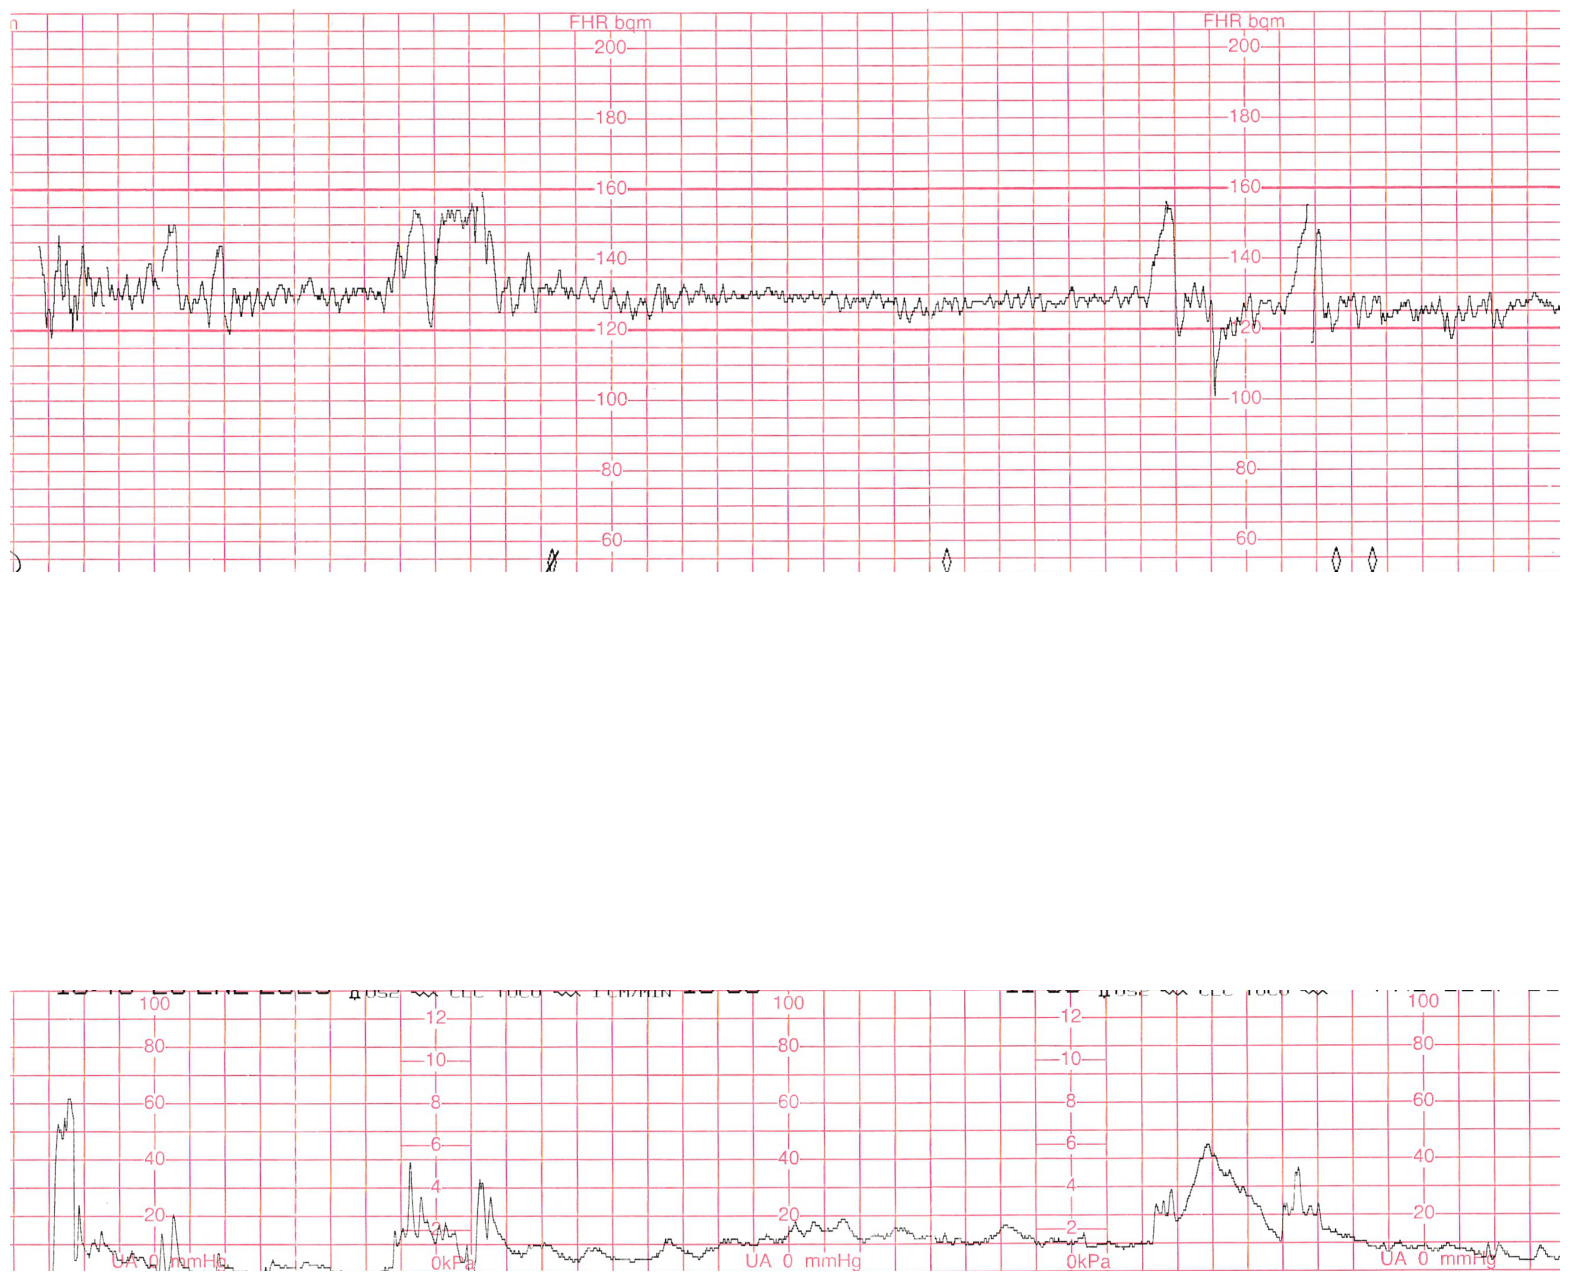

In [418]:
D=io.imread('./crt.jpg')
A1,A2=scan(D)

(50.0, 210.0)

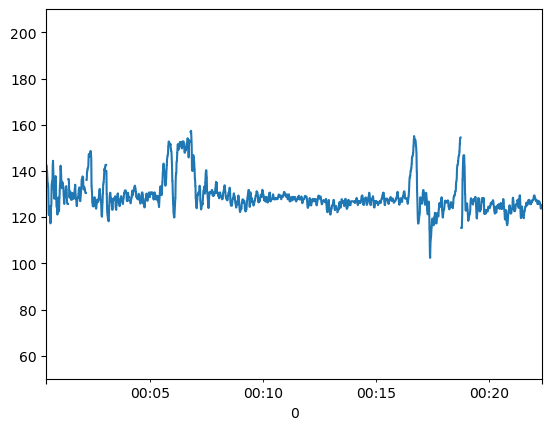

In [419]:
%matplotlib inline
A1.plot()
plt.ylim(50,210)

(0.0, 100.0)

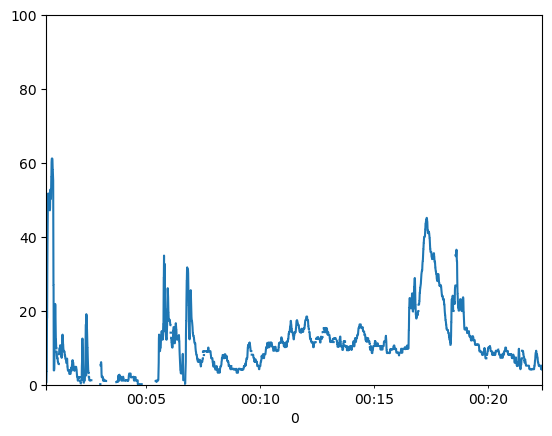

In [420]:
A2.plot()
plt.ylim(0,100)